# Week 6: Colab Experiment

# I. Introduction
In this exercise, we apply dimension reduction methods and clustering algorithms to single-cell sequencing data.

# II. Methods

This code performs clustering analysis on single-cell sequencing data. 

It begins by loading the data, normalizing it by total counts, and applying a log transformation. Then, it uses two models to train the data: PCA, which reduces the dimension of the data, and K-Means clustering, which evaluates the silhouette score across different values of clusters.

In [105]:
#from google.colab import drive
#drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

In [106]:
# Load the data
tasic2018 = np.load('/Users/vincent_tiono/Documents/Machine Learning/week6_colab/cell_data.npz')

# Data normalization and log transform count data
librarySizes = tasic2018['counts'].sum(axis=1)
CPM = tasic2018['counts'] / librarySizes.reshape(-1,1) * 1e+6
logCPM = np.log2(CPM + 1)

In [107]:
# Implement PCA
# Use a PCA object to reduce the dimensions of the data 
# to 2 components for visualization, then transforms the logCPM data
pca = PCA(n_components = 2)
X = pca.fit_transform(logCPM)

In [108]:
# Implement K-Means with optimization using parallel processing

def compute_silhouette_score(k):
    # Initialize a clustering model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=17, n_init='auto')
    # Fit the model to X and predict the cluster for each data
    labels = kmeans.fit_predict(X)
    # Compare the scores which measures how similar an object is to its own cluster compared to other clusters
    # and return the score
    return silhouette_score(X, labels)

# Define the range of k clusters values to test  
k_grid = range(2, 11, 1)
# Run the compute_silhouette_score function in parallel for each k in k_grid
score = Parallel(n_jobs=-1)(delayed(compute_silhouette_score)(k) for k in k_grid)

## III. Results

Here we show the scatter plot of the top 2 PCs. We also show the silhouette score with respect to the number of k-means clusters.

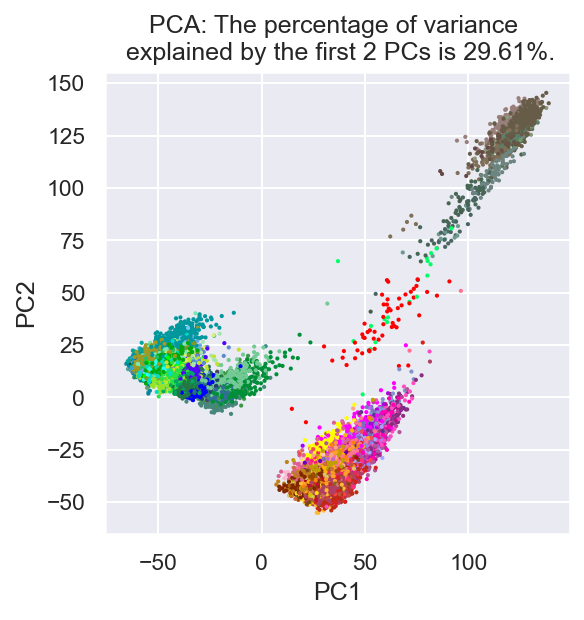

In [109]:
# Principal component analysis scatter plot 

# Adjust the plot to match the baseline result
X[:, 1] = -X[:, 1]
X[:, 0] = -X[:, 0]

# Generate a scatter plot of PCA-transformed data, 
# coloring points by cluster, 
# annotate the plot with % of variance by the first two principal components.
plt.figure(figsize=(4,4), dpi=150)
plt.scatter(X[:,0], X[:,1], s=1, color=tasic2018['clusterColors'][tasic2018['clusters']]) # Note that X is what you defined in PCA
plt.title(f"PCA: The percentage of variance \n explained by the first 2 PCs is {round(sum(pca.explained_variance_ratio_) * 100 , 2)}%.")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


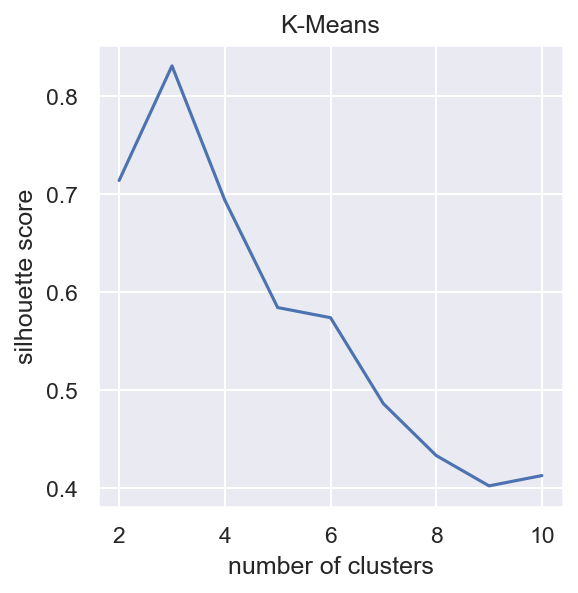

In [110]:
# k-means clustering performance

# Create and display a plot showing
# the graph between the number of clusters and the silhouette score
plt.figure(figsize=(4,4), dpi=150)
plt.plot(k_grid, score)
plt.title('K-Means')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.show()

# IV. Conclusion and Discussion

## Looking at the PCA Plot
When we look at the PCA plot, about 29% of our data can be explained by just the first two components. This means we're capturing some real patterns here, not just noise. The separation of the PCA plot into three distinct groups (green/blue on the bottom left, red/pink in the bottom middle, and brown/grey extending to the top right) indicates that there are likely three underlying clusters or patterns in the data that PCA has revealed. Although there's some mixing in the middle where things get a bit fuzzy, but overall, we can see clear separations. This kind of grouping is what we want when we're using clustering techniques like K-Means.

## What the K-Means Silhouette Scores Tell Us
The silhouette scores gives us some really clear signals - Three clusters seem to be the sweet spot - we hit a score of about 0.85. It means our groups are well-defined and different from each other.

However, when we try to make more clusters, the scores start dropping off. By the time we get to 6 clusters, the scores flatten out at a pretty low level, indicating cluster quality diminishes as the number of clusters increases.

## Why Parallel Computing Makes Such a Difference
In the code, I opted for parallel computing when implementing K-Means, resulting in a significant running time boost from 28 seconds to 12 seconds. Here are the reasons:

1. **Speed Boost**: Rather than having a single CPU core do all the heavy lifting, I split the work across several cores, thus speeding up the distance calculations and updates required in the K-Means algorithm.

2. **What Makes the Original Method So Slow**: The traditional way is performed sequentially on a single core, when we've got thousands or millions of points, that gets time-consuming really fast.

Next, I am going to implemenent another clustering method: Agglomerative Clustering. It starts by treating each data as its own cluster, then merging them until the desired number of clusters is reached. This approach follows a bottom-up approach, namely merging pairs of clusters based on a similarity measure. There are some advantages using Agglomerative Clustering, for example it does not require specifying the number of clusters in advance, making it more flexible. However, unlike PCA, it does not reduce dimensionality, making it computationally expensive and harder to interpret when dealing with high-dimensional data.

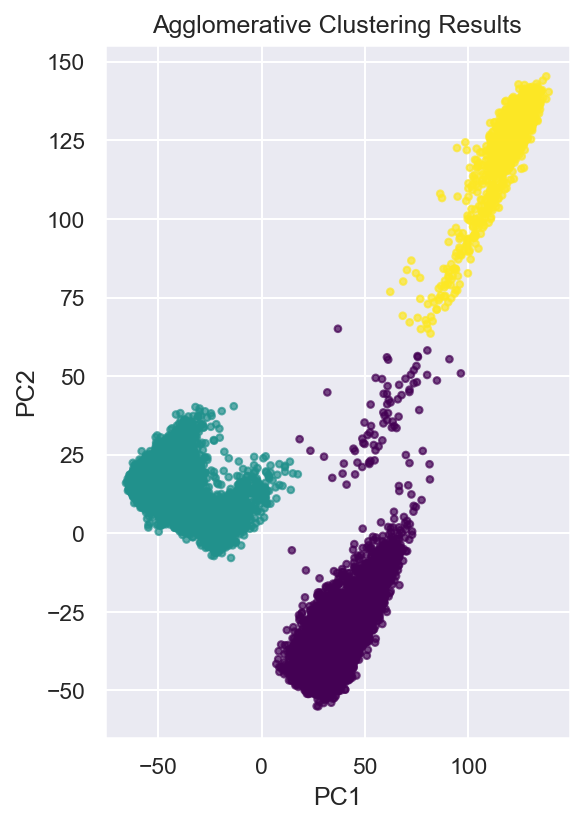

In [112]:
from sklearn.cluster import KMeans, AgglomerativeClustering

# Implement class with 3 clusters to compare the plot with PCA,
# and then fit this model to the data X, 
# assigning cluster labels to each data point.
agglomerative = AgglomerativeClustering(n_clusters = 3)
labels = agglomerative.fit_predict(X)

# Scatter plot of Agglomerative Clustering results
plt.figure(figsize=(4,6), dpi=150)
plt.scatter(X[:, 0], X[:, 1], s=10, c=labels, cmap='viridis', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering Results')
plt.grid(True)
plt.show()

The Agglomerative Clustering results show that the data is divided into three distinct clusters represented by different colors (yellow, turquoise, and purple). Comparing with PCA, Agglomerative Clustering creates clear-cut, definitive boundaries between groups; while PCA reveals a more continuous spectrum of variation across samples. While the discrete grouping offered can help us organize and categorize our samples, the continuous distribution shown in PCA reminds us that biological systems often exist on a gradient rather than in strictly defined groups. As for the running time, Agglomerative Clustering runs for about 5 seconds, longer than PCA which only takes 0.2 seconds. This result matches with the fact that we reduce the dimension first in PCA, therefore it is computationally cheaper.